In [1]:
from qiskit.transpiler.passes.routing.sabre_swap_v020_lookahead import SabreSwap
from qiskit.transpiler.passes.layout.sabre_layout_v020 import SabreLayout
from ulti.circuits import get_circuit_list, sort_circuits_by_depth
from ulti.coupling_maps import file_to_coupling_map
from ulti.pass_managers import generate_pass_managers, transpiled_data
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import random
random.seed(42)
import os

# Runs the experiment for SabreSwap v0.20 lookahead


In [2]:
# Variables to change
qc_name = "size10_depth_10-30"

experiment_name = "sabre_look_1"
version = "20" # version for the routing pass after _v0.
lp_name = "sabre_0.29"
cp_name = "heavy_hex_27"

In [3]:
num_shots = 5
rp = SabreSwap
lp = SabreLayout
cm = file_to_coupling_map(f'coupling_maps/{cp_name}.txt')
pm = generate_pass_managers(num_shots, rp, lp, cm)


rp_name = experiment_name + "_v0." + version
qc_list = get_circuit_list([f'circuits/{qc_name}/'])
qc_list = sort_circuits_by_depth(qc_list)

csv_file_path = f'data/{qc_name}/{experiment_name}_v0{version}.csv'
directory = f'data/{qc_name}'
if not os.path.exists(directory):
        os.makedirs(directory)

In [4]:
data_list = []
for qc_idx, qc in enumerate(qc_list):
    data = transpiled_data(qc, pm)
    data['routing pass'] = rp_name
    data['layout pass'] = lp_name
    data['coupling map'] = cp_name
    data['circuit label'] = qc_idx
    data_list.append(data)

    print(f"Finished {qc_idx}")
print("Finished all")

Finished 0
Finished 1
Finished 2
Finished 3
Finished 4
Finished 5
Finished 6
Finished 7
Finished 8
Finished 9
Finished 10
Finished 11
Finished 12
Finished 13
Finished 14
Finished 15
Finished 16
Finished 17
Finished 18
Finished 19
Finished all


In [5]:
df = pd.DataFrame(data_list)
df.to_csv(csv_file_path, index=False)
df

,best_data,std_dev,routing pass,layout pass,coupling map,circuit label
0,"{'depth': 599, 'depth_ratio': 59.9, 'time': 36...","{'depth': 112.7, 'depth_ratio': 11.27, 'time':...",sabre_look_1_v0.20,sabre_0.29,heavy_hex_27,0
1,"{'depth': 613, 'depth_ratio': 55.73, 'time': 4...","{'depth': 183.3, 'depth_ratio': 16.67, 'time':...",sabre_look_1_v0.20,sabre_0.29,heavy_hex_27,1
2,"{'depth': 491, 'depth_ratio': 40.92, 'time': 3...","{'depth': 300.5, 'depth_ratio': 25.05, 'time':...",sabre_look_1_v0.20,sabre_0.29,heavy_hex_27,2
3,"{'depth': 900, 'depth_ratio': 69.23, 'time': 6...","{'depth': 317.2, 'depth_ratio': 24.4, 'time': ...",sabre_look_1_v0.20,sabre_0.29,heavy_hex_27,3
4,"{'depth': 844, 'depth_ratio': 60.29, 'time': 5...","{'depth': 317.6, 'depth_ratio': 22.69, 'time':...",sabre_look_1_v0.20,sabre_0.29,heavy_hex_27,4
5,"{'depth': 842, 'depth_ratio': 56.13, 'time': 6...","{'depth': 469.7, 'depth_ratio': 31.32, 'time':...",sabre_look_1_v0.20,sabre_0.29,heavy_hex_27,5
6,"{'depth': 1102, 'depth_ratio': 68.88, 'time': ...","{'depth': 311.3, 'depth_ratio': 19.46, 'time':...",sabre_look_1_v0.20,sabre_0.29,heavy_hex_27,6
7,"{'depth': 997, 'depth_ratio': 58.65, 'time': 2...","{'depth': 455.1, 'depth_ratio': 26.77, 'time':...",sabre_look_1_v0.20,sabre_0.29,heavy_hex_27,7
8,"{'depth': 682, 'depth_ratio': 37.89, 'time': 6...","{'depth': 739.1, 'depth_ratio': 41.06, 'time':...",sabre_look_1_v0.20,sabre_0.29,heavy_hex_27,8
9,"{'depth': 1098, 'depth_ratio': 57.79, 'time': ...","{'depth': 345.0, 'depth_ratio': 18.16, 'time':...",sabre_look_1_v0.20,sabre_0.29,heavy_hex_27,9


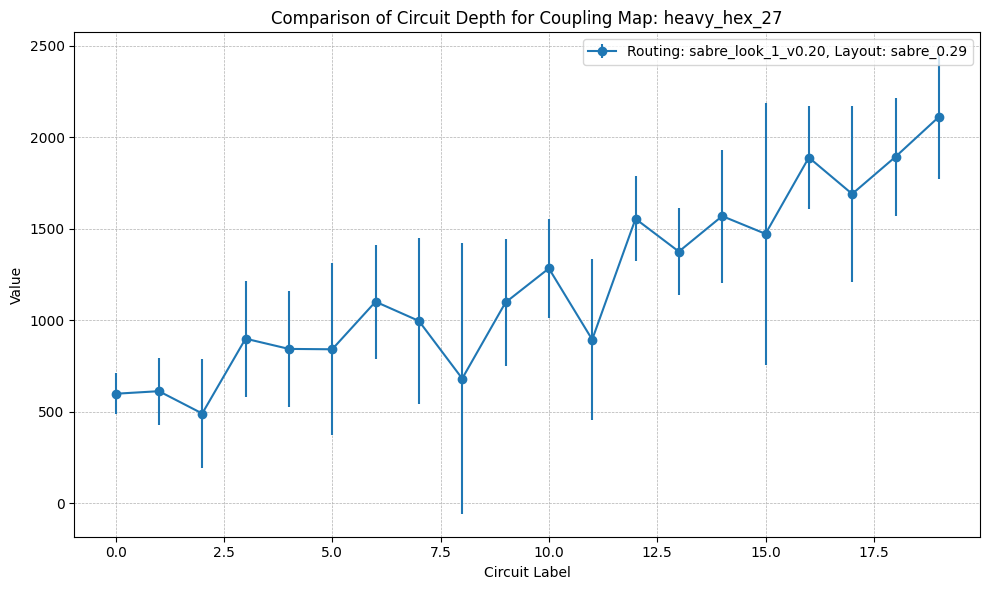

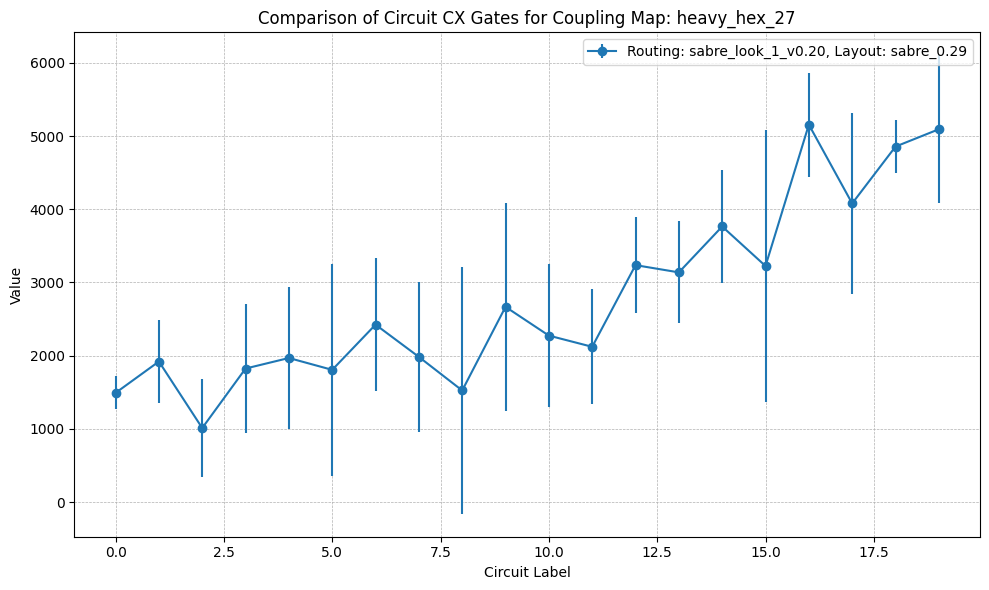

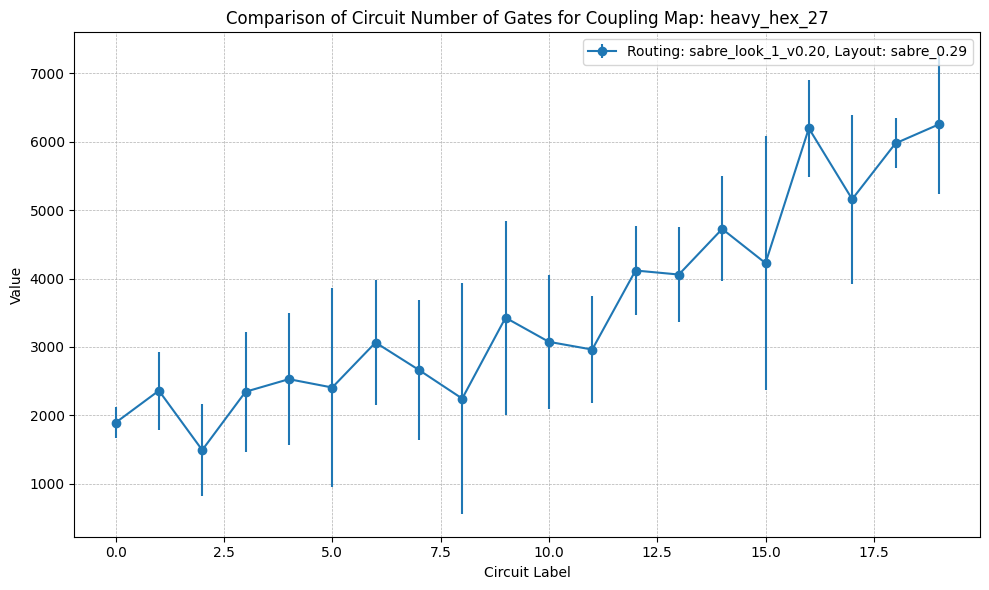

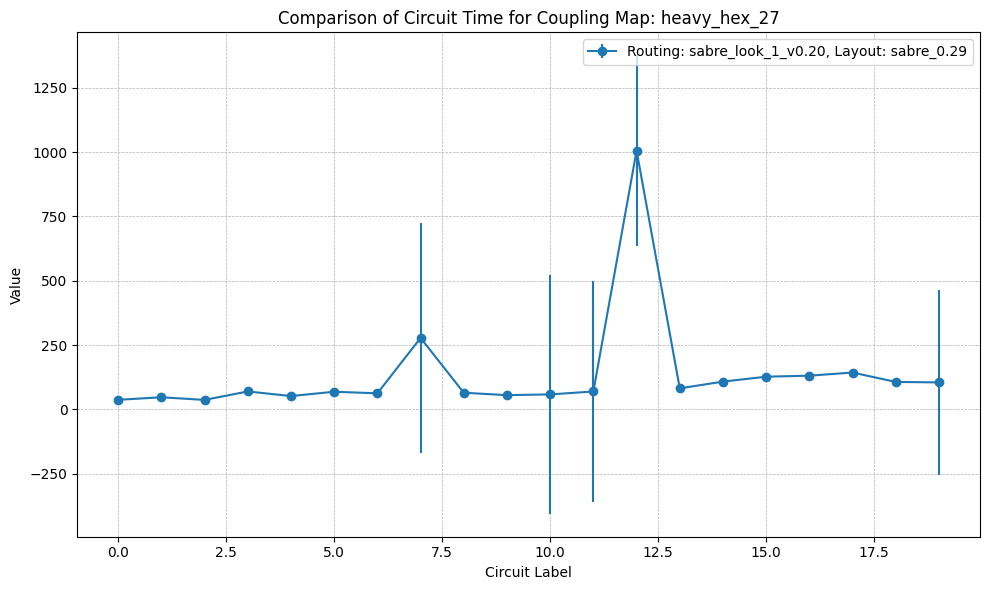

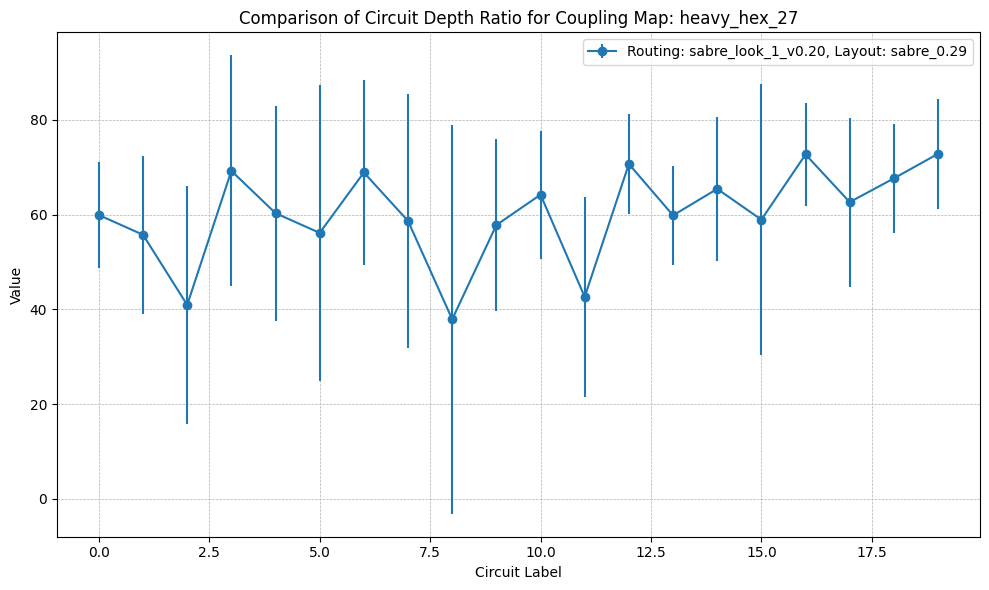

In [6]:
data = pd.read_csv(csv_file_path)

# Convert the string representation of dictionaries into actual dictionaries
data['best_data'] = data['best_data'].apply(literal_eval)
data['std_dev'] = data['std_dev'].apply(literal_eval)

# Extract the data from the 'best_data' and 'std_dev' columns and add them to the DataFrame
for col in ['depth', 'depth_ratio', 'time', 'cx_gates', 'num_gates']:
    data[f"best_{col}"] = data['best_data'].apply(lambda x: x[col])
    data[f"std_dev_{col}"] = data['std_dev'].apply(lambda x: x[col])

metrics = [
    ("depth", "Depth"),
    ("cx_gates", "CX Gates"),
    ("num_gates", "Number of Gates"),
    ("time", "Time"),
    ("depth_ratio", "Depth Ratio")
]

unique_routing_layout_combinations = data[['routing pass', 'layout pass']].drop_duplicates().values

for metric, label in metrics:
    plt.figure(figsize=(10, 6))
    for routing_pass, layout_pass in unique_routing_layout_combinations:
        subset = data[(data['routing pass'] == routing_pass) & (data['layout pass'] == layout_pass)]
        plt.errorbar(subset['circuit label'], subset[f"best_{metric}"], yerr=subset[f"std_dev_{metric}"], fmt='o-', label=f'Routing: {routing_pass}, Layout: {layout_pass}')
    plt.xlabel('Circuit Label')
    plt.ylabel('Value')
    plt.title(f'Comparison of Circuit {label} for Coupling Map: {data["coupling map"].iloc[0]}')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    #plt.savefig(f"data/graphs/{qc_name}/{experiment_name}_v0{version}/{label.replace(' ', '_').lower()}.png")
    plt.show()
    plt.close()